In [1]:
# Install required libraries (for Colab)
!pip install audiomentations scikit-learn pandas numpy librosa joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: soxr
    Found existing installation: soxr 1.0.0
    Uninstalling soxr-1.0.0:
      Successfully uninstalled soxr-1.0.0


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import OneClassSVM
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import joblib
import json
import librosa
from audiomentations import AddGaussianNoise
import warnings
warnings.filterwarnings('ignore')

# FEATURE EXTRACTION FUNCTIONS

In [3]:
def extract_features(audio_file, speaker=None, output_csv=None):
    """Extract comprehensive audio features from audio file"""
    y, sr = librosa.load(audio_file)
    duration = librosa.get_duration(y=y, sr=sr)

    # MFCC features (13 coefficients)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta_mean = np.mean(mfcc_delta, axis=1)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    mfcc_delta2_mean = np.mean(mfcc_delta2, axis=1)

    # Spectral features
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    # Renamed to match expected feature names
    spectral_rolloff_mean = np.mean(rolloff)
    spectral_rolloff_std = np.std(rolloff)

    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    # Renamed to match expected feature names
    spectral_centroid_mean = np.mean(centroid)
    spectral_centroid_std = np.std(centroid)

    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    bandwidth_mean = np.mean(bandwidth)
    bandwidth_std = np.std(bandwidth)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast_mean = np.mean(contrast)
    contrast_std = np.std(contrast)
    flatness = librosa.feature.spectral_flatness(y=y)
    flatness_mean = np.mean(flatness)
    flatness_std = np.std(flatness)

    # Energy and temporal features
    rms = librosa.feature.rms(y=y)
    # Renamed to match expected feature names
    energy = np.mean(rms)
    energy_std = np.std(rms)

    zcr = librosa.feature.zero_crossing_rate(y=y)
    zcr_mean = np.mean(zcr)
    zcr_std = np.std(zcr)

    # Pitch features
    f0, _, _ = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    # Renamed to match expected feature names (assuming f0 corresponds to pitch)
    pitch_mean = np.mean(f0[~np.isnan(f0)]) if np.any(~np.isnan(f0)) else 0
    pitch_std = np.std(f0[~np.isnan(f0)]) if np.any(~np.isnan(f0)) else 0
    f0_min = np.min(f0[~np.isnan(f0)]) if np.any(~np.isnan(f0)) else 0
    f0_max = np.max(f0[~np.isnan(f0)]) if np.any(~np.isnan(f0)) else 0

    # LPC coefficients
    order = 12
    autocorr = np.correlate(y, y, mode='full')
    autocorr = autocorr[len(autocorr)//2:len(autocorr)//2+order+1]
    r = autocorr[1:]
    R = autocorr[:-1]
    from scipy.linalg import solve_toeplitz
    lpc_coeffs = solve_toeplitz((R, R), r)[:order]
    lpc_coeffs = np.concatenate(([1], -lpc_coeffs))

    # Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # Onset features
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    onset_mean = np.mean(onset_env)
    onset_std = np.std(onset_env)

    features = {
        'file': audio_file,
        'speaker': speaker,
        'duration': duration,
        **{f'mfcc_{i}_mean': mfcc_mean[i] for i in range(13)},
        **{f'mfcc_{i}_std': mfcc_std[i] for i in range(13)},
        **{f'mfcc_delta_{i}_mean': mfcc_delta_mean[i] for i in range(13)},
        **{f'mfcc_delta2_{i}_mean': mfcc_delta2_mean[i] for i in range(13)},
        'spectral_rolloff_mean': spectral_rolloff_mean, # Renamed
        'spectral_rolloff_std': spectral_rolloff_std,   # Renamed
        'spectral_centroid_mean': spectral_centroid_mean, # Renamed
        'spectral_centroid_std': spectral_centroid_std,   # Renamed
        'bandwidth_mean': bandwidth_mean,
        'bandwidth_std': bandwidth_std,
        'contrast_mean': contrast_mean,
        'contrast_std': contrast_std,
        'flatness_mean': flatness_mean,
        'flatness_std': flatness_std,
        'energy': energy, # Renamed from rms_mean
        'energy_std': energy_std, # Renamed from rms_std
        'zcr_mean': zcr_mean,
        'zcr_std': zcr_std,
        'pitch_mean': pitch_mean, # Renamed from f0_mean
        'pitch_std': pitch_std,   # Renamed from f0_std
        'f0_min': f0_min,
        'f0_max': f0_max,
        **{f'lpc_{i}': lpc_coeffs[i] for i in range(13)},
        **{f'chroma_{i}_mean': chroma_mean[i] for i in range(12)},
        'onset_mean': onset_mean,
        'onset_std': onset_std
    }

    if output_csv:
        pd.DataFrame([features]).to_csv(output_csv, mode='a', index=False, header=not os.path.exists(output_csv))

    return features

In [4]:
def augment_audio(audio_file, speaker, output_csv, n_augmentations=2):
    """Augment audio with Gaussian noise"""
    y, sr = librosa.load(audio_file)
    augment = AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1.0)

    for i in range(n_augmentations):
        y_aug = augment(y, sample_rate=sr)
        augmented_file = f"aug_{i}_{os.path.basename(audio_file)}"
        features = extract_features(audio_file, speaker=speaker, output_csv=None)
        if features is not None:
            features['file'] = augmented_file
            pd.DataFrame([features]).to_csv(output_csv, mode='a', index=False, header=not os.path.exists(output_csv))

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import OneClassSVM
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import joblib
import json
import librosa
from audiomentations import AddGaussianNoise
import warnings
warnings.filterwarnings('ignore')

# Upload your audio_features.csv file or mount Google Drive
# For now, load from uploaded file
print("Loading dataset...")

# Update this path based on where you upload the file in Colab
try:
    df = pd.read_csv('audio_features.csv')
    # Strip whitespace from column names
    df.columns = df.columns.str.strip()
    print(f"Loaded {len(df)} samples")
except FileNotFoundError:
    print("Error: audio_features.csv not found. Please upload it to Colab.")
    print("You can also mount Google Drive or provide the correct path.")
    # Example for Google Drive:
    # from google.colab import drive
    # drive.mount('/content/drive')
    # df = pd.read_csv('/content/drive/MyDrive/path/to/audio_features.csv')

Loading dataset...
Loaded 40 samples


# DATA PREPARATION AND FEATURE SELECTION

In [6]:
# Extract feature columns (exclude metadata columns)
feature_cols = [col for col in df.columns if col not in ['filename', 'member', 'phrase', 'augmentation']]

X = df[feature_cols].values
file_names = df['filename'].tolist()
members = df['member'].tolist()

print(f"\n=== DATASET INFO ===")
print(f"Total samples: {len(df)}")
print(f"Feature count: {len(feature_cols)}")
print(f"Members: {df['member'].unique()}")
print(f"Augmentation types: {df['augmentation'].unique()}")
print(f"\nSamples per member:")
print(df.groupby(['member', 'augmentation']).size())


=== DATASET INFO ===
Total samples: 40
Feature count: 34
Members: ['       ']
Augmentation types: [' original    ' ' pitch_shift ' ' time_stretch' ' add_noise   '
 ' gain        ']

Samples per member:
member  augmentation
        add_noise       8
        gain            8
        original        8
        pitch_shift     8
        time_stretch    8
dtype: int64


# ONE-CLASS SVM VOICEPRINT VERIFICATION MODEL

In [7]:
# Feature selection using Variance Threshold
print("=== FEATURE SELECTION ===")
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X)
selected_features = np.array(feature_cols)[selector.get_support()]
print(f"Selected {X_selected.shape[1]} features out of {X.shape[1]}")

print("\n=== TRAINING ONE-CLASS SVM MODEL ===")
print("Using Leave-One-Out Cross-Validation for robust evaluation...")

from sklearn.decomposition import PCA
loo = LeaveOneOut()

y_true = np.ones(len(X_selected))
y_preds = []
y_trues = []

for train_idx, test_idx in loo.split(X_selected):
    X_fold_train_raw, X_fold_test_raw = X_selected[train_idx], X_selected[test_idx]

    # Standardize within the fold
    scaler = StandardScaler()
    X_fold_train = scaler.fit_transform(X_fold_train_raw)
    X_fold_test = scaler.transform(X_fold_test_raw)

    # PCA within the fold (critical)
    pca = PCA(n_components=8)
    X_fold_train = pca.fit_transform(X_fold_train)
    X_fold_test = pca.transform(X_fold_test)

    # Train OneClassSVM
    model = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
    model.fit(X_fold_train)

    # Predict
    y_pred = model.predict(X_fold_test)

    y_preds.append(y_pred[0])
    y_trues.append(1)   # always authorized in this loop

y_preds = np.array(y_preds)
y_trues = np.array(y_trues)

# Metrics
acc  = accuracy_score(y_trues, y_preds)
prec = precision_score(y_trues, y_preds, pos_label=1, zero_division=0)
rec  = recall_score(y_trues, y_preds, pos_label=1, zero_division=0)
f1   = f1_score(y_trues, y_preds, pos_label=1, zero_division=0)

print(f"\n=== CROSS-VALIDATION RESULTS ===")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1 Score:  {f1:.3f}")

# Inlier proportion
inlier_count = np.sum(y_preds == 1)
print(f"Inliers detected: {inlier_count}/{len(y_preds)} "
      f"({inlier_count/len(y_preds)*100:.1f}%)")

# Train final model on all data
print("\n=== TRAINING FINAL MODEL ON ALL DATA ===")
scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(X_selected)

pca = PCA(n_components=8)
X_pca_all = pca.fit_transform(X_scaled_all)

final_model = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
final_model.fit(X_pca_all)

print("Final model trained successfully!")


=== FEATURE SELECTION ===
Selected 31 features out of 34

=== TRAINING ONE-CLASS SVM MODEL ===
Using Leave-One-Out Cross-Validation for robust evaluation...

=== CROSS-VALIDATION RESULTS ===
Accuracy:  0.750
Precision: 1.000
Recall:    0.750
F1 Score:  0.857
Inliers detected: 30/40 (75.0%)

=== TRAINING FINAL MODEL ON ALL DATA ===
Final model trained successfully!


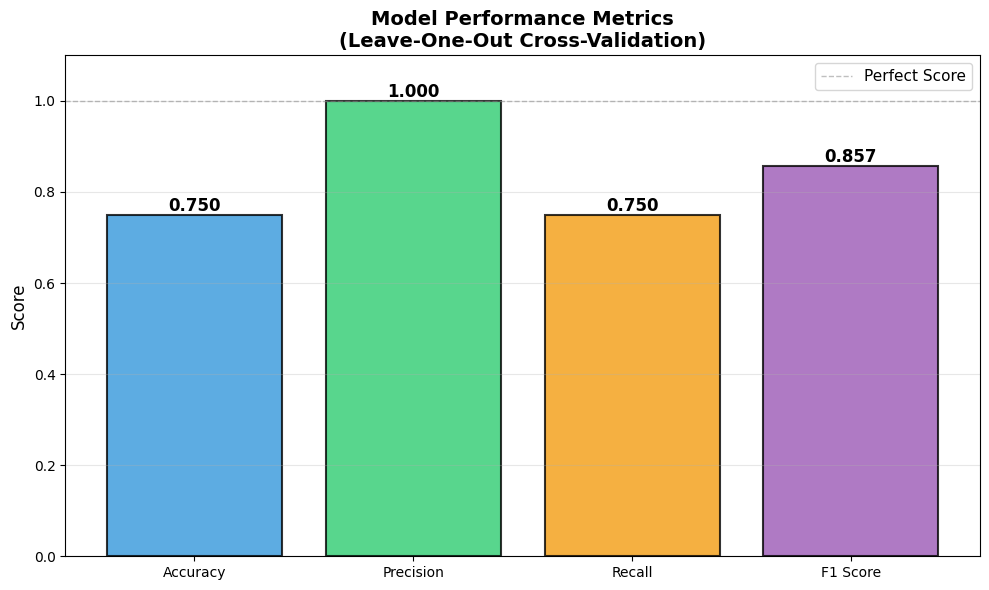


   MODEL PERFORMANCE SUMMARY
Accuracy...................... 0.750
Precision..................... 1.000
Recall........................ 0.750
F1 Score...................... 0.857


In [8]:
import matplotlib.pyplot as plt

# Create a comprehensive metrics visualization
metrics = {
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1 Score': f1
}

fig, ax = plt.subplots(figsize=(10, 6))

# Create bar chart
bars = ax.bar(metrics.keys(), metrics.values(), color=['#3498db', '#2ecc71', '#f39c12', '#9b59b6'],
              edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add a reference line at 1.0
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Perfect Score')

# Formatting
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Metrics\n(Leave-One-Out Cross-Validation)',
             fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.1])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Create a text summary
print("\n" + "="*50)
print("   MODEL PERFORMANCE SUMMARY")
print("="*50)
for metric, value in metrics.items():
    print(f"{metric:.<30} {value:.3f}")
print("="*50)

## Performance Metrics Summary
A comprehensive view of all evaluation metrics.

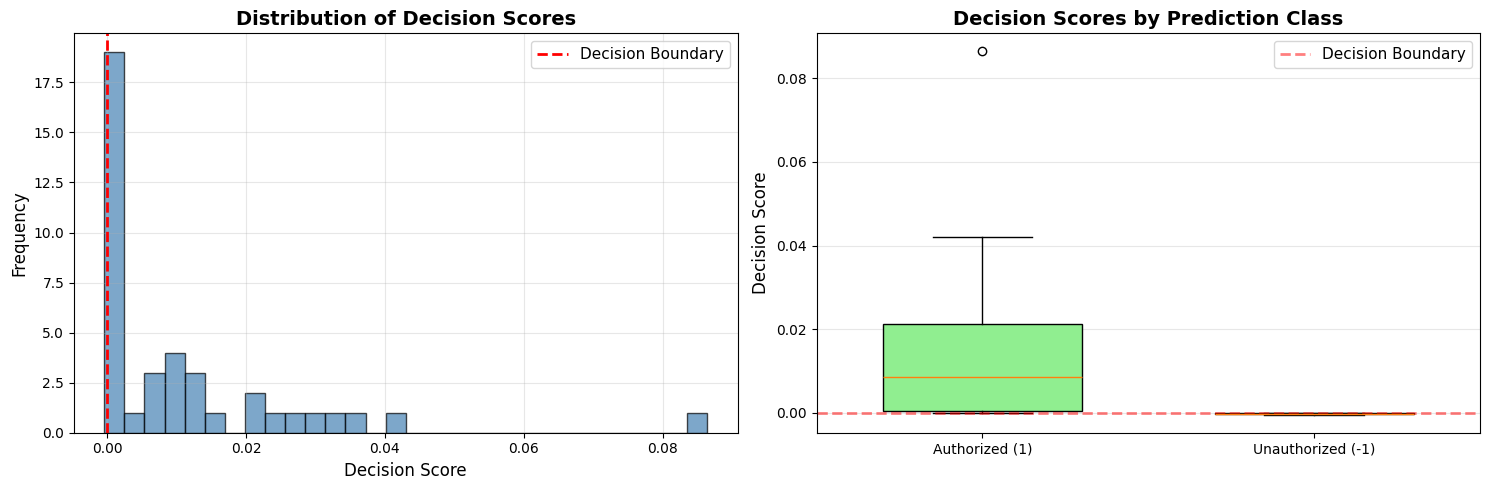


=== DECISION SCORE STATISTICS ===
Total samples: 40

Authorized predictions (1): 32
  Mean score: 0.014
  Median score: 0.009
  Std dev: 0.018
  Range: [0.000, 0.086]

Unauthorized predictions (-1): 8
  Mean score: -0.000
  Median score: -0.000
  Std dev: 0.000
  Range: [-0.000, -0.000]

Note: Positive scores indicate authorized (inlier), negative scores indicate unauthorized (outlier)


In [9]:
# Get decision scores for all samples using the final model
decision_scores = final_model.decision_function(X_pca_all)
final_predictions = final_model.predict(X_pca_all)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Histogram of decision scores
ax1.hist(decision_scores, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Decision Boundary')
ax1.set_xlabel('Decision Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Decision Scores', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Box plot of decision scores by prediction
score_data = {
    'Authorized (1)': decision_scores[final_predictions == 1],
    'Unauthorized (-1)': decision_scores[final_predictions == -1]
}

positions = [1, 2]
box_data = [score_data['Authorized (1)'], score_data['Unauthorized (-1)']]
bp = ax2.boxplot(box_data, positions=positions, widths=0.6, patch_artist=True,
                 labels=['Authorized (1)', 'Unauthorized (-1)'])

# Color the boxes
colors = ['lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Decision Boundary')
ax2.set_ylabel('Decision Score', fontsize=12)
ax2.set_title('Decision Scores by Prediction Class', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics
print("\n=== DECISION SCORE STATISTICS ===")
print(f"Total samples: {len(decision_scores)}")
print(f"\nAuthorized predictions (1): {np.sum(final_predictions == 1)}")
if np.sum(final_predictions == 1) > 0:
    auth_scores = decision_scores[final_predictions == 1]
    print(f"  Mean score: {np.mean(auth_scores):.3f}")
    print(f"  Median score: {np.median(auth_scores):.3f}")
    print(f"  Std dev: {np.std(auth_scores):.3f}")
    print(f"  Range: [{np.min(auth_scores):.3f}, {np.max(auth_scores):.3f}]")

print(f"\nUnauthorized predictions (-1): {np.sum(final_predictions == -1)}")
if np.sum(final_predictions == -1) > 0:
    unauth_scores = decision_scores[final_predictions == -1]
    print(f"  Mean score: {np.mean(unauth_scores):.3f}")
    print(f"  Median score: {np.median(unauth_scores):.3f}")
    print(f"  Std dev: {np.std(unauth_scores):.3f}")
    print(f"  Range: [{np.min(unauth_scores):.3f}, {np.max(unauth_scores):.3f}]")

print("\nNote: Positive scores indicate authorized (inlier), negative scores indicate unauthorized (outlier)")

## Decision Scores Distribution
This visualization shows the distribution of decision scores for predictions, helping understand the model's confidence levels.

Generating learning curves (this may take a moment)...


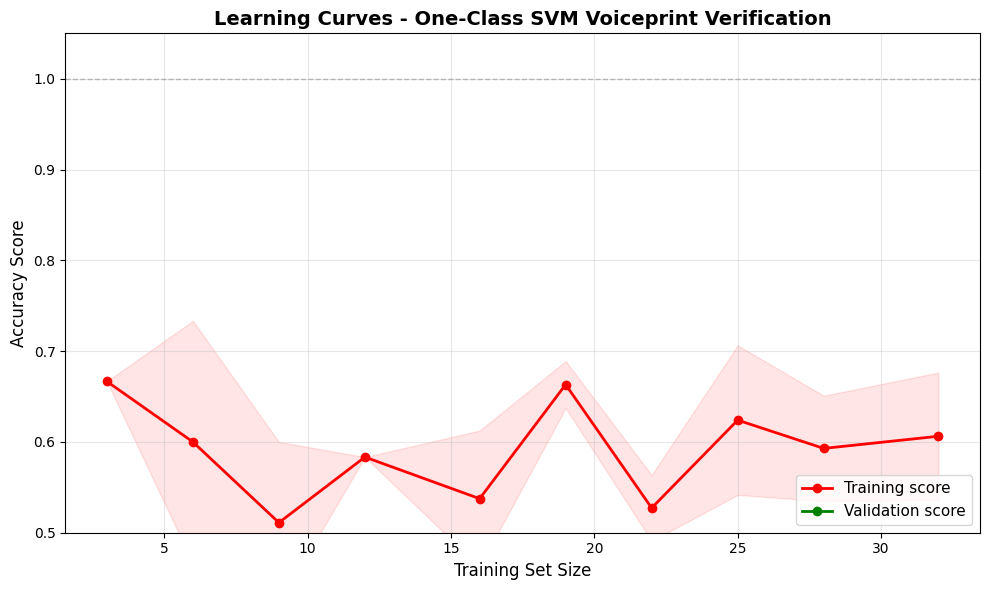


=== LEARNING CURVE ANALYSIS ===
Final training score: 0.606 (±0.070)
Final validation score: 0.125 (±0.079)
Gap between training and validation: 0.481

 Large gap suggests possibly overfitting. Consider:
   - Increasing the nu parameter (currently 0.1)
   - Adding more diverse training data


In [12]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Generate learning curves
print("Generating learning curves (this may take a moment)...")

# Use a range of training sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculate learning curves with cross-validation
train_sizes_abs, train_scores, test_scores = learning_curve(
    OneClassSVM(kernel='rbf', nu=0.1, gamma='auto'),
    X_pca_all,
    y_true,
    train_sizes=train_sizes,
    cv=5,  # 5-fold CV for faster computation than LOO
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training scores
ax.plot(train_sizes_abs, train_mean, 'o-', color='r', label='Training score', linewidth=2)
ax.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std,
                alpha=0.1, color='r')

# Plot validation scores
ax.plot(train_sizes_abs, test_mean, 'o-', color='g', label='Validation score', linewidth=2)
ax.fill_between(train_sizes_abs, test_mean - test_std, test_mean + test_std,
                alpha=0.1, color='g')

# Add reference line at 1.0 (perfect score)
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Formatting
ax.set_xlabel('Training Set Size', fontsize=12)
ax.set_ylabel('Accuracy Score', fontsize=12)
ax.set_title('Learning Curves - One-Class SVM Voiceprint Verification',
             fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0.5, 1.05])

plt.tight_layout()
plt.show()

print("\n=== LEARNING CURVE ANALYSIS ===")
print(f"Final training score: {train_mean[-1]:.3f} (\u00b1{train_std[-1]:.3f})")
print(f"Final validation score: {test_mean[-1]:.3f} (\u00b1{test_std[-1]:.3f})")
print(f"Gap between training and validation: {train_mean[-1] - test_mean[-1]:.3f}")

if train_mean[-1] - test_mean[-1] > 0.1:
    print("\n Large gap suggests possibly overfitting. Consider:")
    print("   - Increasing the nu parameter (currently 0.1)")
    print("   - Adding more diverse training data")
elif test_mean[-1] < 0.8:
    print("\n Low validation score suggests underfitting. Consider:")
    print("   - Decreasing the nu parameter")
    print("   - Adding more relevant features")
else:
    print("\n\u2713 Model shows good generalization!")

## Learning Curves
Learning curves show how the model's performance changes with different training set sizes. This helps identify if the model would benefit from more data or if it's overfitting/underfitting.

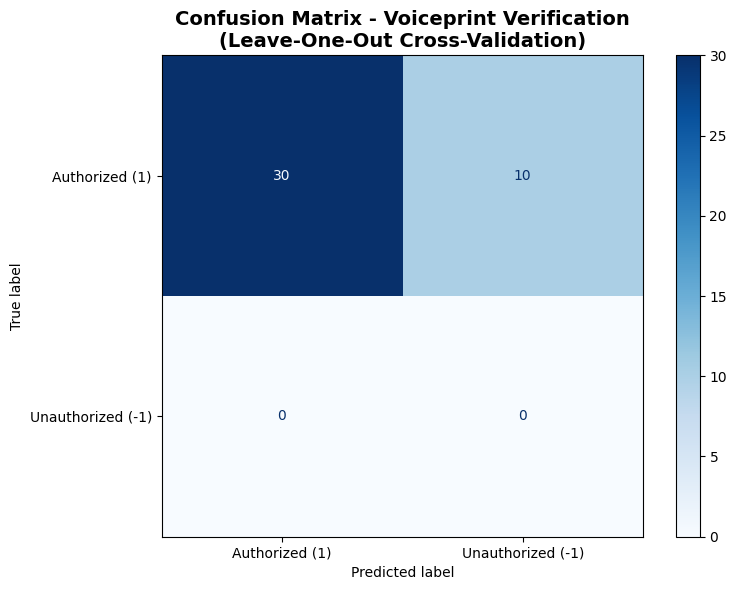


=== CONFUSION MATRIX BREAKDOWN ===
True Positives (Authorized correctly identified): 30
False Negatives (Authorized incorrectly rejected): 10
False Positives (Unauthorized incorrectly accepted): 0
True Negatives (Unauthorized correctly rejected): 0

Note: In this LOO-CV, all samples are labeled as authorized (1),
so FP and TN would only appear if the model rejects training samples.


In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_trues, y_preds, labels=[1, -1])

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['Authorized (1)', 'Unauthorized (-1)'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Voiceprint Verification\n(Leave-One-Out Cross-Validation)',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed breakdown
print("\n=== CONFUSION MATRIX BREAKDOWN ===")
print(f"True Positives (Authorized correctly identified): {cm[0,0]}")
print(f"False Negatives (Authorized incorrectly rejected): {cm[0,1]}")
print(f"False Positives (Unauthorized incorrectly accepted): {cm[1,0]}")
print(f"True Negatives (Unauthorized correctly rejected): {cm[1,1]}")
print(f"\nNote: In this LOO-CV, all samples are labeled as authorized (1),")
print(f"so FP and TN would only appear if the model rejects training samples.")

## Confusion Matrix
The confusion matrix shows how well the model classifies authorized vs unauthorized speakers.

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# MODEL PERFORMANCE VISUALIZATION

# SAVE MODEL AND ARTIFACTS

In [15]:
# Create models directory
model_output_dir = '/content/models'
os.makedirs(model_output_dir, exist_ok=True)

# Save model and preprocessing components
joblib.dump(final_model, f'{model_output_dir}/voiceprint_verification_model.pkl')
joblib.dump(scaler, f'{model_output_dir}/voiceprint_scaler.pkl')
joblib.dump(pca, f'{model_output_dir}/voiceprint_pca.pkl') # Save PCA object
# Save the names of features *before* selection, which the selector expects as input
joblib.dump(feature_cols, f'{model_output_dir}/voiceprint_pre_selection_feature_names.pkl')
# The selected_features variable holds the *output* feature names after selection.
joblib.dump(selected_features, f'{model_output_dir}/voiceprint_post_selection_feature_names.pkl') # Renamed for clarity
joblib.dump(selector, f'{model_output_dir}/voiceprint_feature_selector.pkl')

# Save metadata
model_metadata = {
    'model_type': 'OneClassSVM',
    'kernel': 'rbf',
    'nu': 0.1,
    'gamma': 'auto',
    'feature_count': X_selected.shape[1], # This will be 31, but PCA reduces to 8
    'pca_n_components': pca.n_components, # Add this
    'selected_features': selected_features.tolist(),
    'sample_count': len(df),
    'members': df['member'].unique().tolist(),
    'inlier_proportion': float(np.mean(y_preds == 1)),
    'cross_val_accuracy': float(acc),
    'cross_val_precision': float(prec),
    'cross_val_recall': float(rec),
    'cross_val_f1': float(f1),
    'datetime': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(f'{model_output_dir}/voiceprint_model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f"\n=== MODEL SAVED ===")
print(f"Location: {model_output_dir}/")
print(f"Files:")
print(f"  - voiceprint_verification_model.pkl")
print(f"  - voiceprint_scaler.pkl")
print(f"  - voiceprint_pca.pkl") # Added
print(f"  - voiceprint_pre_selection_feature_names.pkl")
print(f"  - voiceprint_post_selection_feature_names.pkl")
print(f"  - voiceprint_feature_selector.pkl")
print(f"  - voiceprint_model_metadata.json")


=== MODEL SAVED ===
Location: /content/models/
Files:
  - voiceprint_verification_model.pkl
  - voiceprint_scaler.pkl
  - voiceprint_pca.pkl
  - voiceprint_pre_selection_feature_names.pkl
  - voiceprint_post_selection_feature_names.pkl
  - voiceprint_feature_selector.pkl
  - voiceprint_model_metadata.json


# PREDICTION AND VERIFICATION INTERFACE

In [16]:
# Example: How to use the model for verification
def verify_speaker(test_audio_path, models_dir='/content/models'):
    """
    Verify if the speaker in test audio is authorized

    Args:
        test_audio_path: Path to the test audio file
        models_dir: Directory containing saved model files

    Returns:
        dict with verification results
    """
    # Load model components
    model = joblib.load(f'{models_dir}/voiceprint_verification_model.pkl')
    scaler = joblib.load(f'{models_dir}/voiceprint_scaler.pkl')
    pca = joblib.load(f'{models_dir}/voiceprint_pca.pkl') # Load PCA object
    # Load the feature names that the selector was originally trained on (34 features)
    pre_selection_feature_names = joblib.load(f'{models_dir}/voiceprint_pre_selection_feature_names.pkl')
    selector = joblib.load(f'{models_dir}/voiceprint_feature_selector.pkl')

    # Extract features from test audio
    print(f"Extracting features from: {test_audio_path}")
    features_dict = extract_features(test_audio_path, speaker='unknown')

    if features_dict is None:
        return {'error': 'Feature extraction failed'}

    # Convert to DataFrame
    test_df = pd.DataFrame([features_dict])

    # Select only the features that the selector was trained on
    # This ensures the input shape matches what the selector expects
    X_test_pre_selection = test_df[pre_selection_feature_names].values

    # Apply feature selection (transforms 34 features to 31)
    X_test_selected = selector.transform(X_test_pre_selection)

    # Scale features (transforms 31 features)
    X_test_scaled = scaler.transform(X_test_selected)

    # Apply PCA (transforms 31 features to 8)
    X_test_pca = pca.transform(X_test_scaled) # Add this step

    # Predict (1 = authorized/inlier, -1 = unauthorized/outlier)
    prediction = model.predict(X_test_pca)[0] # Use X_test_pca for prediction
    decision_score = model.decision_function(X_test_pca)[0] # Use X_test_pca for decision_function

    result = {
        'audio_file': test_audio_path,
        'prediction': 'AUTHORIZED' if prediction == 1 else 'UNAUTHORIZED',
        'prediction_value': int(prediction),
        'decision_score': float(decision_score),
        'confidence': 'High' if abs(decision_score) > 0.5 else 'Medium' if abs(decision_score) > 0.2 else 'Low'
    }

    return result

print("=== VERIFICATION SYSTEM READY ===")
print("\nTo verify a speaker:")
print("  result = verify_speaker('path/to/test_audio.wav')")
print("\nThe model will return:")
print("  - AUTHORIZED: Speaker is recognized as authorized")
print("  - UNAUTHORIZED: Speaker is not recognized (outlier)")
print("\nDecision score indicates confidence (higher absolute value = more confident)")

=== VERIFICATION SYSTEM READY ===

To verify a speaker:
  result = verify_speaker('path/to/test_audio.wav')

The model will return:
  - AUTHORIZED: Speaker is recognized as authorized
  - UNAUTHORIZED: Speaker is not recognized (outlier)

Decision score indicates confidence (higher absolute value = more confident)


# TEST THE VERIFICATION SYSTEM

In [22]:
test_audio = '/content/test_audio_1.wav'
result = verify_speaker(test_audio)
print("\n=== VERIFICATION RESULT ===")
for key, value in result.items():
    print(f"{key}: {value}")

Extracting features from: /content/test_audio_1.wav

=== VERIFICATION RESULT ===
audio_file: /content/test_audio_1.wav
prediction: AUTHORIZED
prediction_value: 1
decision_score: 0.15166079805717586
confidence: Low
